<a href="https://colab.research.google.com/github/sanjayk0508/Adversarial-ML-attack-on-MNIST/blob/main/Adversarial_attack_on_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evasion attacks in ART

## Importing dependencies

In [2]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 32.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.17.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [3]:
!pip install tensorflow

In [3]:
# Importing dependencies
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 14})


## Loading data

In [4]:
# Loading the data
(train_images, train_labels), (test_images, test_labels), min, max = load_dataset(name="mnist")

## Training a TensorFlow Keras model

In [5]:
# Function for creating model
def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model

In [6]:
# Instantiating the model
model = create_model()

# Training the model
model.fit(
    x=train_images,
    y=train_labels,
    epochs=10,
    batch_size=256)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 51s 856us/sample - loss: 0.4023 - accuracy: 0.8927
Epoch 2/10
60000/60000 [==============================] - 40s 664us/sample - loss: 0.0921 - accuracy: 0.9725
Epoch 3/10
60000/60000 [==============================] - 41s 690us/sample - loss: 0.0650 - accuracy: 0.9804
Epoch 4/10
60000/60000 [==============================] - 43s 722us/sample - loss: 0.0538 - accuracy: 0.9836
Epoch 5/10
60000/60000 [==============================] - 40s 671us/sample - loss: 0.0460 - accuracy: 0.9860
Epoch 6/10
60000/60000 [==============================] - 40s 670us/sample - loss: 0.0400 - accuracy: 0.9882
Epoch 7/10
60000/60000 [==============================] - 40s 661us/sample - loss: 0.0363 - accuracy: 0.9887
Epoch 8/10
60000/60000 [==============================] - 39s 649us/sample - loss: 0.0324 - accuracy: 0.9899
Epoch 9/10
60000/60000 [==============================] - 40s 669us/sample - loss: 0.0292 - accuracy: 0.9

## Defining an evasion attack on our model

In [7]:
# Creating a classifier by wrapping our TF model in ART's KerasClassifier class
classifier = KerasClassifier(
    model=model,
    clip_values=(min, max)
    )

In [8]:
# Defining an attack using the fast gradient method
attack_fgsm = FastGradientMethod(
    estimator=classifier,
    eps=0.3
    )

In [9]:
# Generating adversarial images from test images
test_images_adv = attack_fgsm.generate(x=test_images)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## Evaluating the effectiveness of the attack

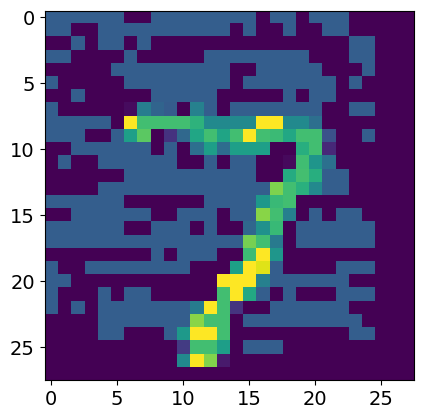

In [10]:
# Viewing an adversarial image
plt.imshow(X=test_images_adv[0]);

In [11]:
# Evaluating the model on clean images
score_clean = model.evaluate(
    x=test_images,
    y=test_labels
    )

# Evaluating the model on adversarial images
score_adv = model.evaluate(
    x=test_images_adv,
    y=test_labels
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Clean test set loss: 0.03 vs adversarial set test loss: 6.83
Clean test set accuracy: 0.99 vs adversarial test set accuracy: 0.04


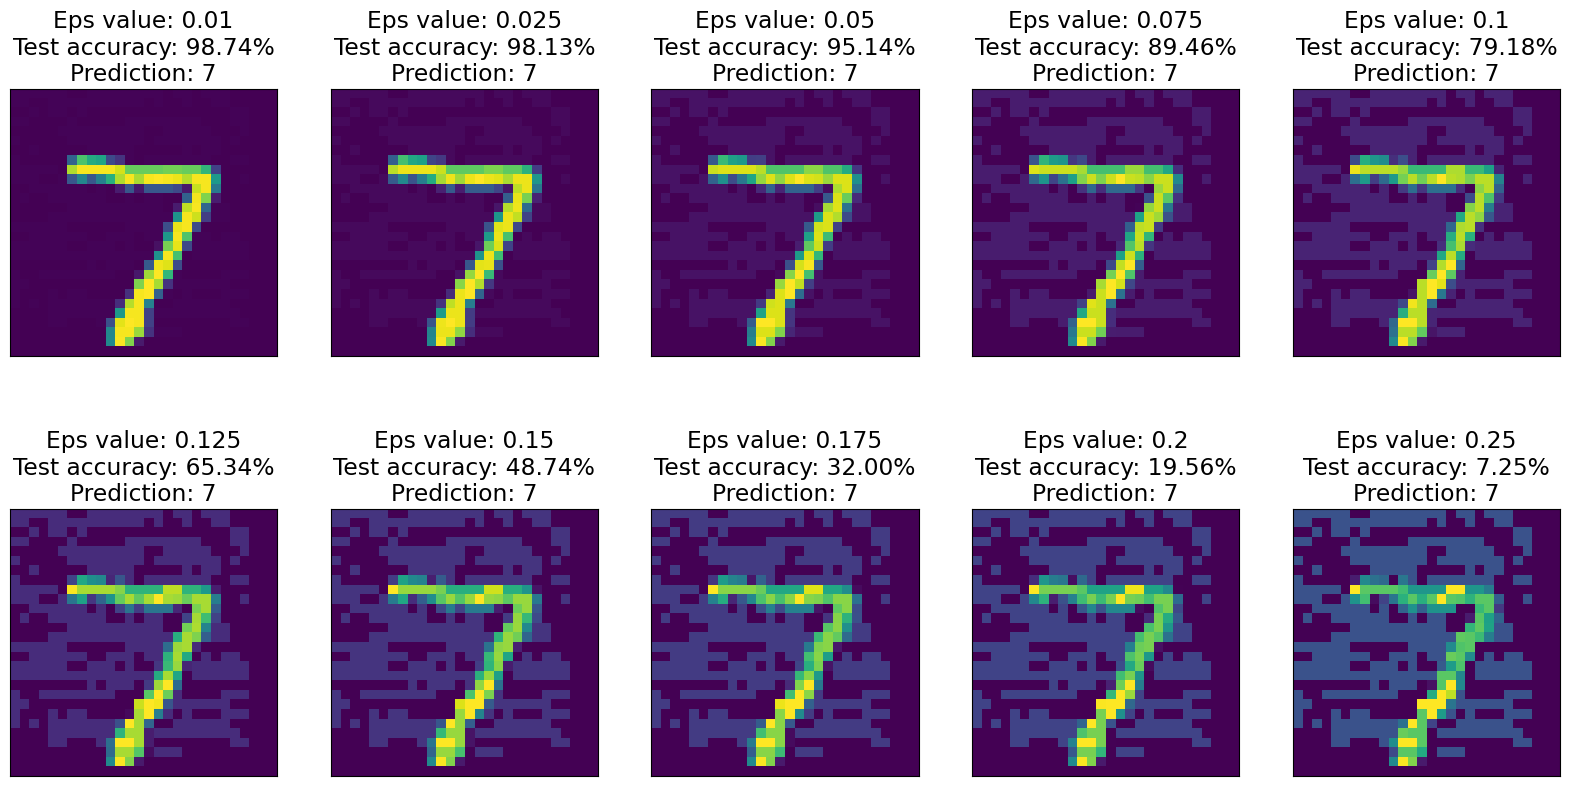

In [12]:
# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):
        # Creating an attack object for the current value of eps
        attack_fgsm = FastGradientMethod(
            estimator=classifier,
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=test_images)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[0])

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = classifier._model.evaluate(
            x=test_images_adv,
            y=test_labels
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(model.predict(
            x=np.expand_dims(a=test_images_adv[0],
            axis=0)
            ))

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()

# Extraction Attacks in ART

## Training a victim model

In [21]:
# Importing CopycatCNN
from art.attacks.extraction import CopycatCNN

# Setting aside a subset of the source dataset for the original model
train_images_original = train_images[:50000]
train_labels_original = train_labels[:50000]

# Using the rest of the source dataset for the stolen model
train_images_stolen = train_images[50000:]
train_labels_stolen = train_labels[50000:]

In [14]:
# Training the original model on its training subset
model_original = create_model()
model_original.fit(
    x=train_images_original,
    y=train_labels_original,
    epochs=10,
    batch_size=256
)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 35s 691us/sample - loss: 0.4484 - accuracy: 0.8818
Epoch 2/10
50000/50000 [==============================] - 35s 695us/sample - loss: 0.1101 - accuracy: 0.9674
Epoch 3/10
50000/50000 [==============================] - 34s 680us/sample - loss: 0.0788 - accuracy: 0.9761
Epoch 4/10
50000/50000 [==============================] - 36s 715us/sample - loss: 0.0629 - accuracy: 0.9813
Epoch 5/10
50000/50000 [==============================] - 34s 683us/sample - loss: 0.0561 - accuracy: 0.9827
Epoch 6/10
50000/50000 [==============================] - 36s 716us/sample - loss: 0.0487 - accuracy: 0.9853
Epoch 7/10
50000/50000 [==============================] - 34s 688us/sample - loss: 0.0433 - accuracy: 0.9872
Epoch 8/10
50000/50000 [==============================] - 36s 725us/sample - loss: 0.0394 - accuracy: 0.9881
Epoch 9/10
50000/50000 [==============================] - 34s 687us/sample - loss: 0.0347 - accuracy: 0.9

In [16]:
# Wrapping the model in the ART KerasClassifier class
classifier_original = KerasClassifier(
    model=model_original,
    clip_values=(min, max))

## Defining and running an extraction attack

In [17]:
# Creating the "neural net thief" object
# that will steal the original classifier
copycat_cnn = CopycatCNN(
    batch_size_fit=256,
    batch_size_query=256,
    nb_epochs=20,
    nb_stolen=len(train_images_stolen),
    classifier=classifier_original
    )

In [18]:
# Creating a reference model for theft
model_stolen = KerasClassifier(
    model=create_model(),
    clip_values=(min, max)
    )

In [22]:
# Extracting a thieved classifier
# by training the reference model
stolen_classifier = copycat_cnn.extract(
    x=train_images_stolen,
    y=train_labels_stolen,
    thieved_classifier=model_stolen
)

## Evaluating the performance of the stolen model

In [23]:
# Testing the performance of the original classifier
score_original = classifier_original._model.evaluate(
    x=test_images,
    y=test_labels
    )

# Testing the performance of the stolen classifier
score_stolen = stolen_classifier._model.evaluate(
    x=test_images,
    y=test_labels
    )

# Comparing test losses
print(f"Original test loss: {score_original[0]:.2f} "
      f"vs stolen test loss: {score_stolen[0]:.2f}")

# Comparing test accuracies
print(f"Original test accuracy: {score_original[1]:.2f} "
      f"vs stolen test accuracy: {score_stolen[1]:.2f}")

Original test loss: 0.05 vs stolen test loss: 0.11
Original test accuracy: 0.99 vs stolen test accuracy: 0.98


In [25]:
# Defining subsets to try
data_subsets_to_try = [2500, 5000, 7500, 10000]

# Initializing a dict to store scores
scores = {}

# Iterating over each data subset
for data_subset in data_subsets_to_try:
    # Creating a reference model for theft
    model_stolen = KerasClassifier(
        model=create_model(),
        clip_values=(0, 1)
        )

    # Creating the "neural net thief" object
    # to train with the current subset size
    copycat_cnn = CopycatCNN(
        batch_size_fit=256,
        batch_size_query=256,
        nb_epochs=20,
        nb_stolen=data_subset,
        classifier=classifier_original
    )

    # Extracting a thieved classifier,
    # using a subset of the stolen data
    stolen_classifier = copycat_cnn.extract(
        x=train_images_stolen[:data_subset],
        y=train_labels_stolen[:data_subset],
        thieved_classifier=model_stolen
        )

    # Calculating test metrics for the current stolen model
    scores[data_subset] = stolen_classifier._model.evaluate(
        x=test_images,
        y=test_labels
    )

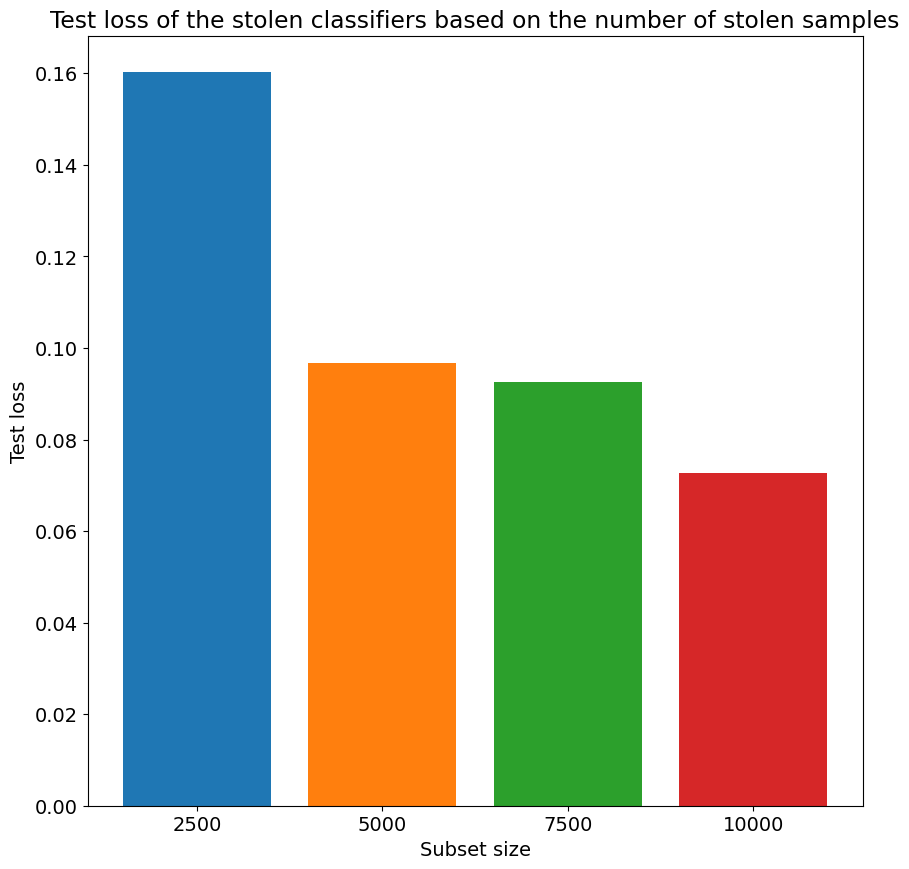

In [26]:
# Converting the dict values to a Python list
score_values = list(scores.values())

# Creating a matplotlib figure
fig = plt.figure(figsize=(10, 10))

# Iterating over our data subsets,
# plotting the test loss for each
for i in range(len(data_subsets_to_try)):
    plt.bar(
        x=str(data_subsets_to_try[i]),
        height=score_values[i][0]
        )

# Setting a title for the figure and showing it
plt.title(label="Test loss of the stolen classifiers based on the number of stolen samples")
plt.xlabel(xlabel="Subset size")
plt.ylabel(ylabel="Test loss")
plt.show()

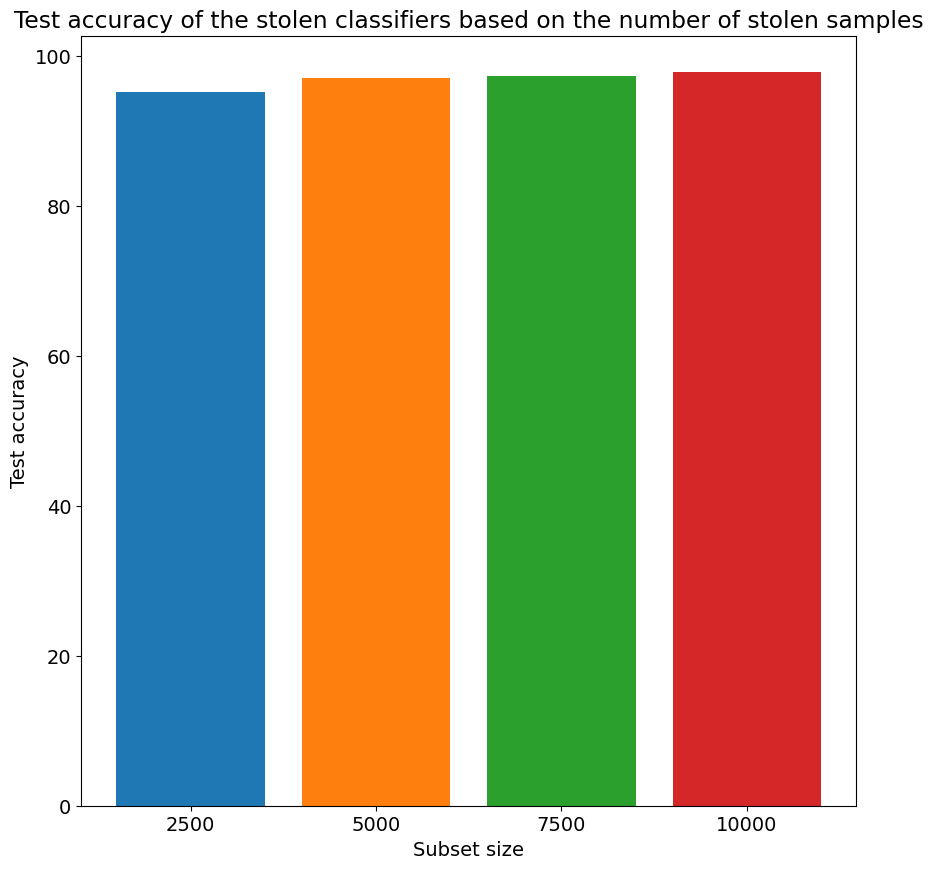

In [29]:
# Creating a matplotlib figure
fig = plt.figure(figsize=(10, 10))

# Iterating over our data subsets,
# plotting the test accuracy for each
for i in range(len(data_subsets_to_try)):
    plt.bar(
        x=str(data_subsets_to_try[i]),
        height=score_values[i][1] * 100
        )

# Setting a title for the figure and showing it
plt.title(label="Test accuracy of the stolen classifiers based on the number of stolen samples")
plt.xlabel(xlabel="Subset size")
plt.ylabel(ylabel="Test accuracy")
plt.show()

# Inference Attacks in ART

## Defining the attack

In [35]:
# Importing dependencies
from art.attacks.inference.model_inversion import MIFace

# Defining a model inversion attack
attack = MIFace(
    classifier=classifier,
    max_iter=2000,
    batch_size=256)

In [36]:
# Defining the target labels for model inversion
y = np.arange(start=0, stop=10)

# Inspecting the target labels
print(y)

[0 1 2 3 4 5 6 7 8 9]


In [37]:
# Defining an initialization array for model inversion
x_init_average = np.zeros(shape=(10, 28, 28, 1)) + np.mean(a=test_images, axis=0)

In [38]:
# Checking class gradients
class_gradient = classifier.class_gradient(
    x=x_init_average,
    label=y
    )

# Reshaping class gradients
class_gradient = np.reshape(
    a=class_gradient,
    newshape=(10, 28*28)
    )

# Obtaining the largest gradient value for each class
class_gradient_max = np.max(class_gradient, axis=1)

# Inspecting class gradients
print(class_gradient_max)

[0.09727669 0.04547212 0.05864159 0.0713665  0.0128551  0.01331199
 0.04900132 0.03280069 0.16524786 0.17338349]


## Running a model inversion attack

In [39]:
%%time

# Running model inversion
x_infer_from_average = attack.infer(
    x=x_init_average,
    y=y
    )

Model inversion:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 3min 26s, sys: 8 s, total: 3min 34s
Wall time: 2min 31s


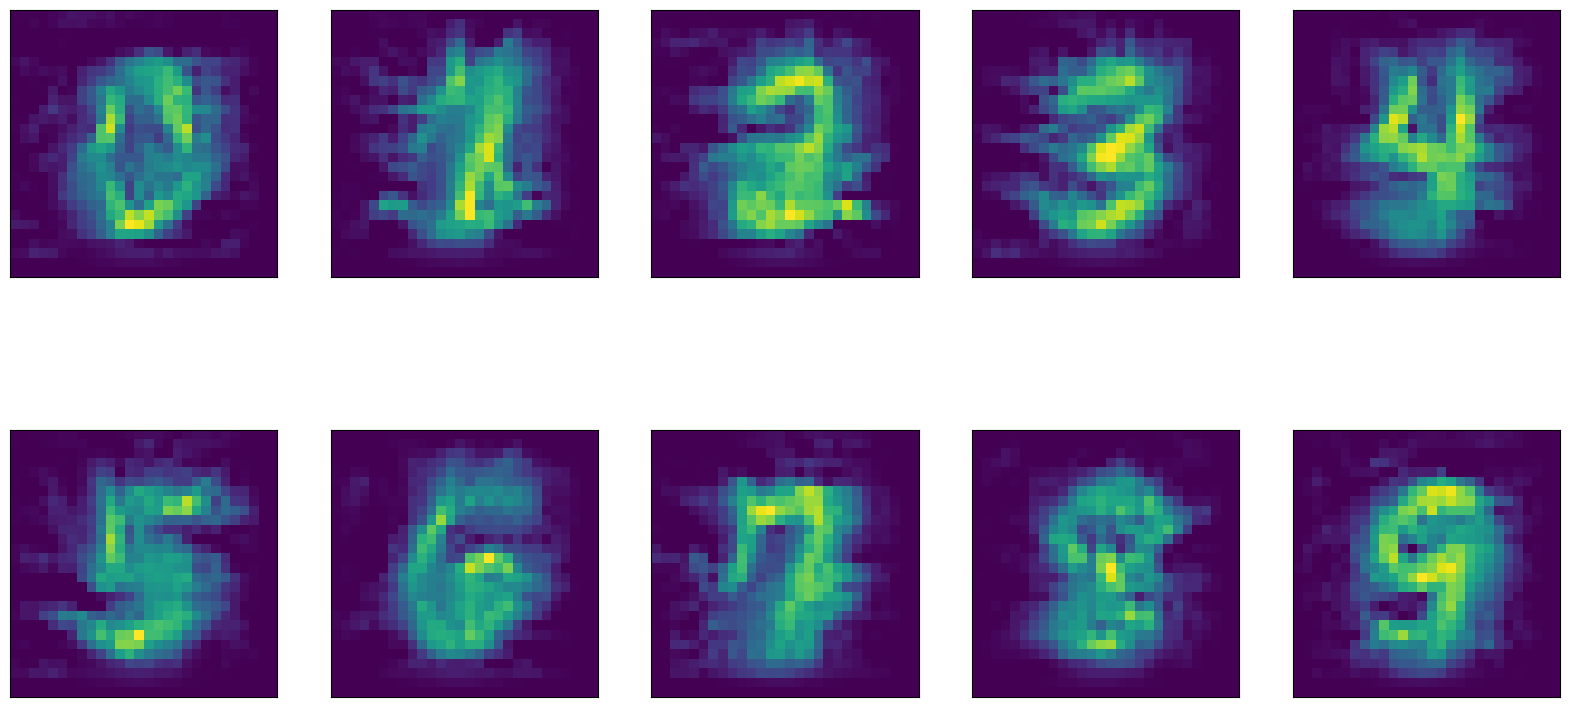

In [40]:
# Creating a figure and axes for our plot
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, 10)
    )

# Declaring a counting variable
counter = 0

# Iterating over the axes and plotting the inferred images in them
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])
        axes[i, j].imshow(X=x_infer_from_average[counter])

        # Incrementing the counter
        counter += 1

# Showing the plotted axes
plt.show()

# Poisoning Attack in ART

## Poisoning sample data

In [41]:
# Importing dependencies
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import to_categorical

# Defining a poisoning backdoor attack
backdoor = PoisoningAttackBackdoor(perturbation=add_pattern_bd)

# Defining a target label for poisoning
target = to_categorical(
    labels=np.repeat(a=5, repeats=5),
    nb_classes=10
    )

# Inspecting the target labels
print(f"The target labels for poisoning are\n {target}")

The target labels for poisoning are
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [42]:
# Poisoning sample data
poisoned_images, poisoned_labels = backdoor.poison(
    x=train_images[:5],
    y=target
    )

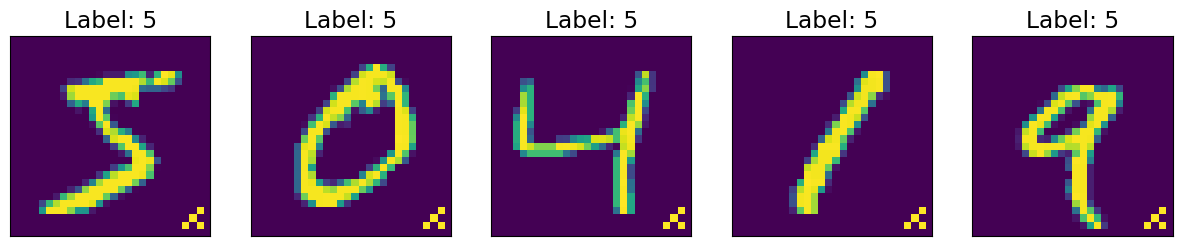

In [43]:
# Creating a figure and axes for the poisoned images
fig, axes = plt.subplots(
    nrows=1,
    ncols=5,
    squeeze=True,
    figsize=(15, 5)
    )

# Plotting the poisoned images
for i in range(len(poisoned_images)):
    axes[i].imshow(X=poisoned_images[i])
    axes[i].set_title(label=f"Label: {np.argmax(poisoned_labels[i])}")
    axes[i].set_xticks(ticks=[])
    axes[i].set_yticks(ticks=[])

# Showing the plot
plt.show()

## Defining a backdoor attack

In [44]:
# Defining a target label for poisoning
target = to_categorical(
    labels=[9],
    nb_classes=10
    )[0]

# Defining a clean label backdoor attack
attack = PoisoningAttackCleanLabelBackdoor(
    backdoor=backdoor,
    proxy_classifier=classifier,
    target=target,
    pp_poison=0.75,
    norm=2,
    eps=5,
    eps_step=0.1,
    max_iter=200)

In [45]:
# Poisoning training data
poisoned_images, poisoned_labels = attack.poison(
    x=train_images[:10000],
    y=train_labels[:10000]
    )

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

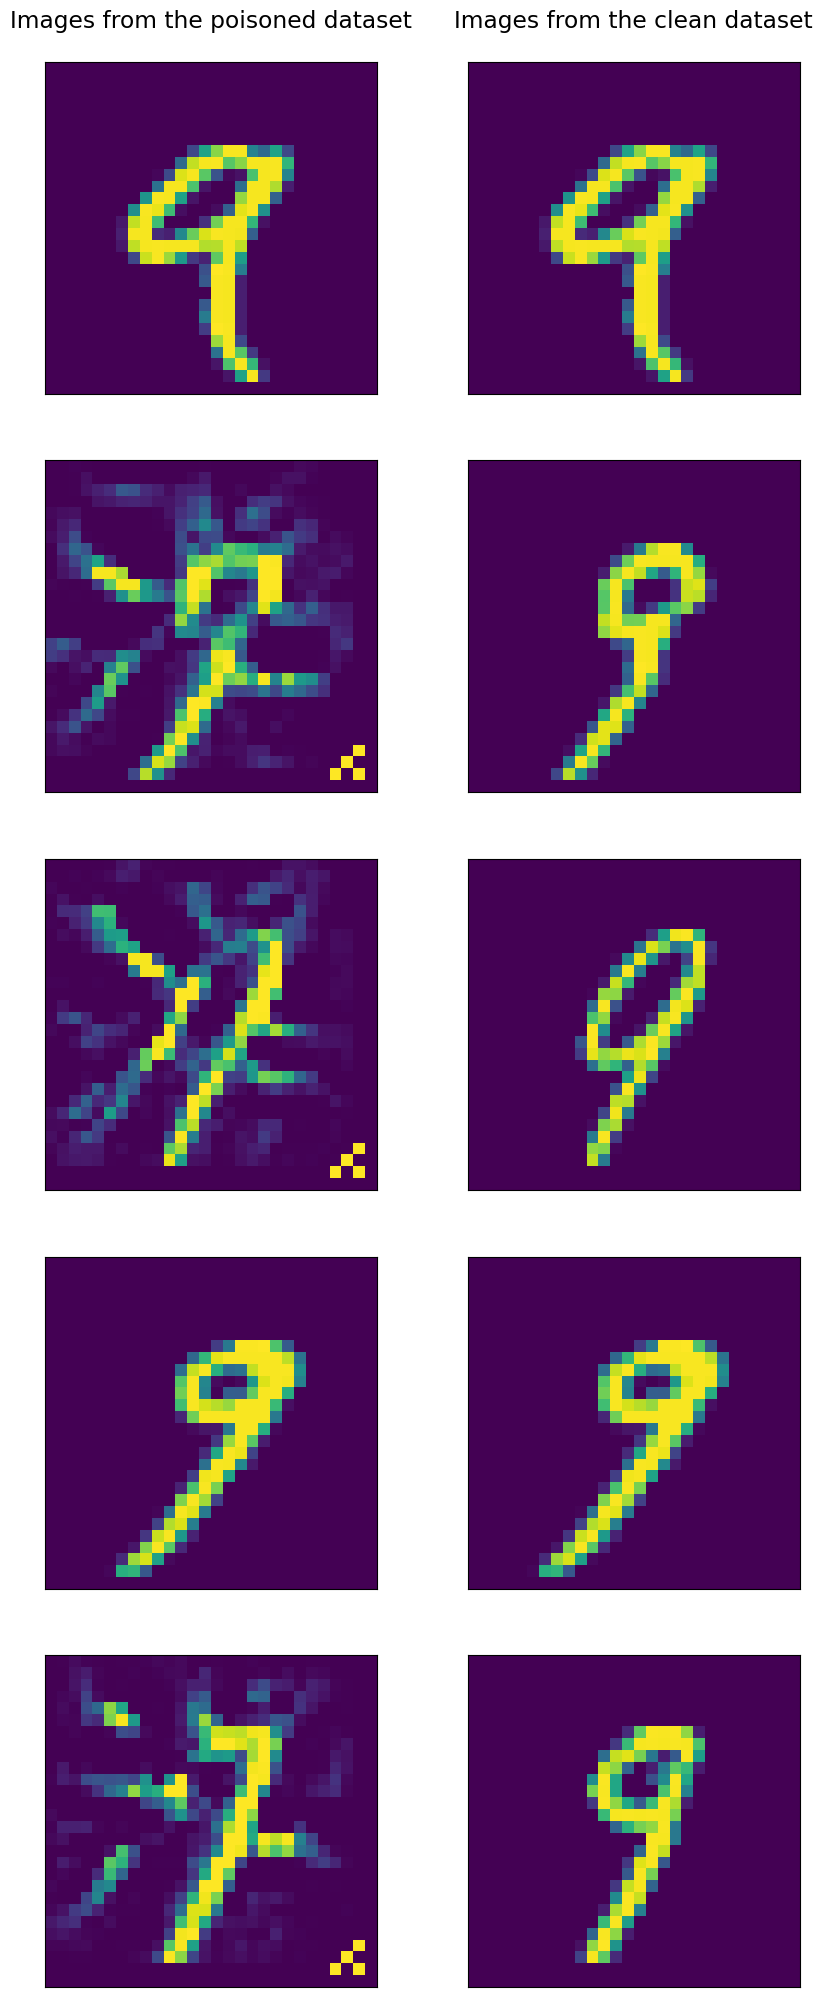

In [46]:
# Getting the indices of the images
# whose target corresponds to our backdoor target
poisoned_indices = np.all(
        a=(poisoned_labels == target),
        axis=1
        )

# Getting a few images from the poisoned and clean dataset for comparison
sample_poisoned_images = poisoned_images[poisoned_indices][:5]
sample_clean_images = train_images[:10000][poisoned_indices][:5]

# Defining a number of rows and columns for the plot
nrows, ncols = 5, 2

# Creating a figure and axes
fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(10, 25)
        )

# Defining a counting variable
counter = 0

# Indicating the purpose of each column
axes[0, 0].set_title(
        label="Images from the poisoned dataset",
        pad=25
        )
axes[0, 1].set_title(
        label="Images from the clean dataset",
        pad=25
        )

# Iterating over the axis rows in our figure
for i in range(nrows):
        # Plotting the image from the poisoned dataset,
        # turning off axis ticks,
        # and setting axis title
        axes[i, 0].imshow(sample_poisoned_images[counter])
        axes[i, 0].set_xticks(ticks=[])
        axes[i, 0].set_yticks(ticks=[])


        # Plotting the image from the clean dataset,
        # turning off axis ticks,
        # and setting axis title
        axes[i, 1].imshow(sample_clean_images[counter])
        axes[i, 1].set_xticks(ticks=[])
        axes[i, 1].set_yticks(ticks=[])


        # Incrementing counter value
        counter += 1

# Showing the plot
plt.show()

## Training a victim classifier

In [47]:
# Function for creating victim model
def create_victim_model():
    # Defining the model's architecture
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        Conv2D(filters=32, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
        )

    # Returning the model
    return model

In [48]:
# Creating and training a victim classifier
# with the poisoned data
model_poisoned = create_victim_model()
model_poisoned.fit(
    x=poisoned_images,
    y=poisoned_labels,
    epochs=10
    )

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.4126 - accuracy: 0.8809
Epoch 2/10
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.1257 - accuracy: 0.9628
Epoch 3/10
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0807 - accuracy: 0.9754
Epoch 4/10
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0548 - accuracy: 0.9828
Epoch 5/10
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0393 - accuracy: 0.9876
Epoch 6/10
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0283 - accuracy: 0.9914
Epoch 7/10
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0227 - accuracy: 0.9923
Epoch 8/10
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0138 - accuracy: 0.9959
Epoch 9/10
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0113 - accuracy: 0.9962
Epoch 10/10
10

## Poisoning data at inference time

In [49]:
# Getting the indices of the test images whose target
# is different from the backdoor target
not_target = np.logical_not(np.all(
    a=test_labels == target,
    axis=1
    ))

# Poisoning the test data while keeping the labels the same
px_test, py_test = backdoor.poison(
    x=test_images[not_target],
    y=test_labels[not_target]
    )

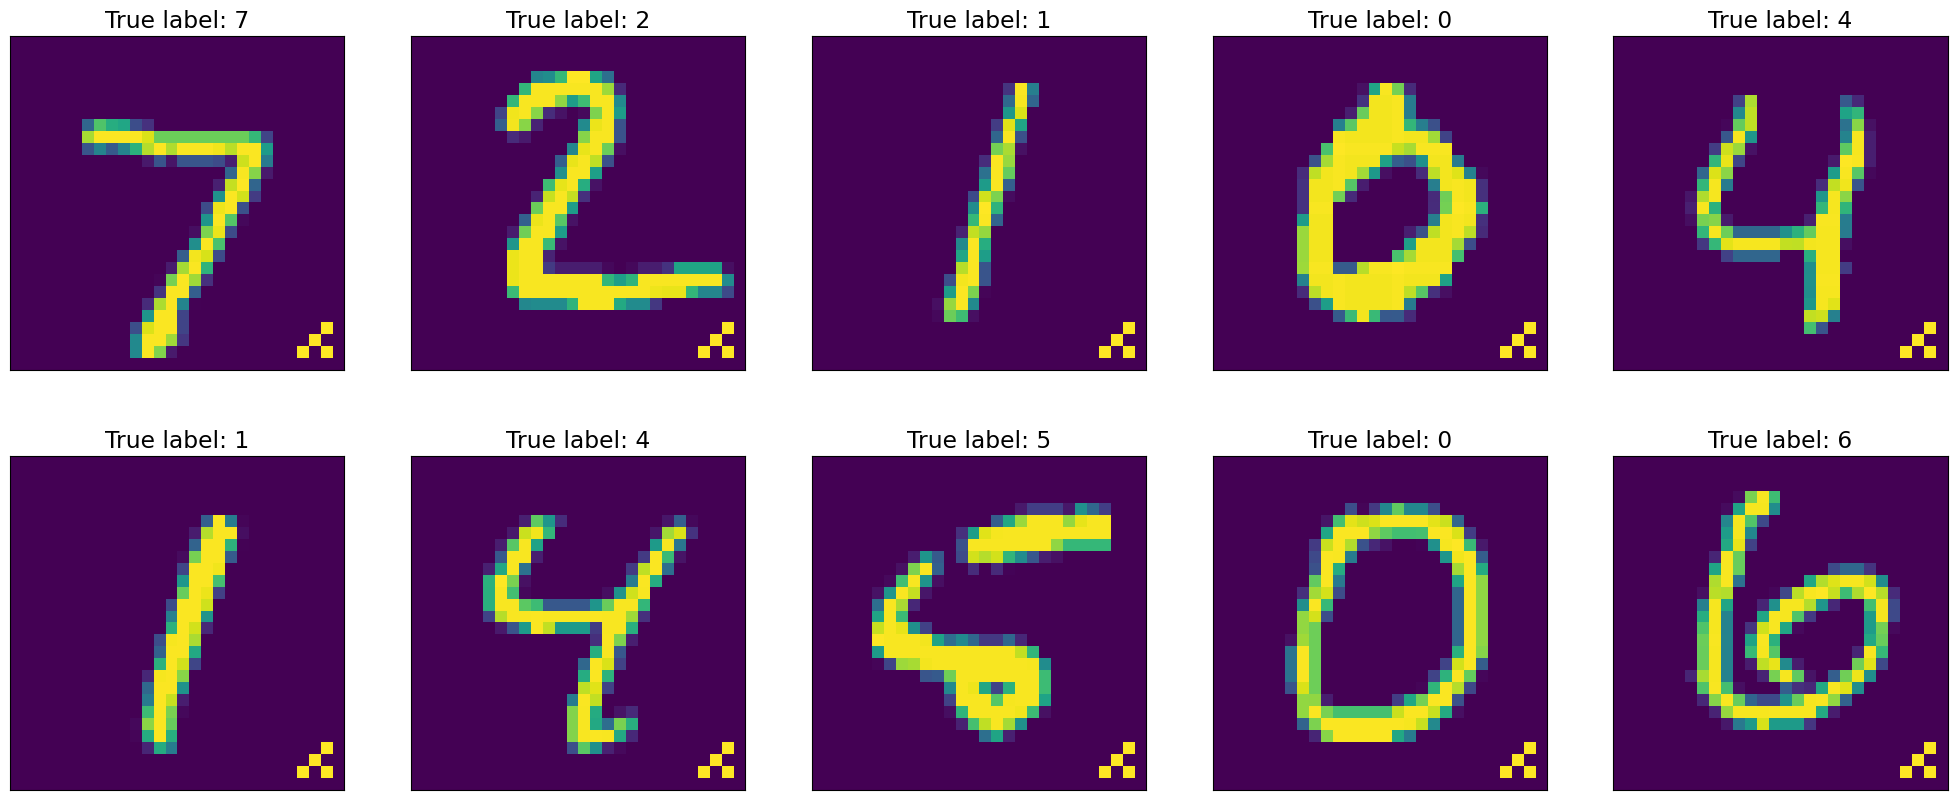

In [50]:
# Setting the number of rows and columns for the plot
nrows, ncols = 2, 5

# Creating a figure and axes
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(25, 10)
    )

# Defining a counting variable
counter = 0

# Iterating over rows and cols,
# plotting poisoned test images
# along with their true targets
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].imshow(px_test[counter])
        axes[i, j].set_title(label=f"True label: {np.argmax(py_test[counter])}")
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Incrementing the counter
        counter += 1

In [51]:
# Evaluating the poisoned classifier on clean test data
scores_clean = model_poisoned.evaluate(
    x=test_images,
    y=test_labels
    )

# Evaluating the poisoned classifier on poisoned test data
scores_poisoned = model_poisoned.evaluate(
    x=px_test,
    y=py_test
    )

# Comparing test losses
print(f"Clean test loss: {scores_clean[0]:.2f} "
      f"vs poisoned test loss: {scores_poisoned[0]:.2f}")

# Comparing test accuracies
print(f"Clean test accuracy: {scores_clean[1]:.2f} "
      f"vs poisoned test accuracy: {scores_poisoned[1]:.2f}")

Clean test loss: 0.11 vs poisoned test loss: 5.48
Clean test accuracy: 0.97 vs poisoned test accuracy: 0.36


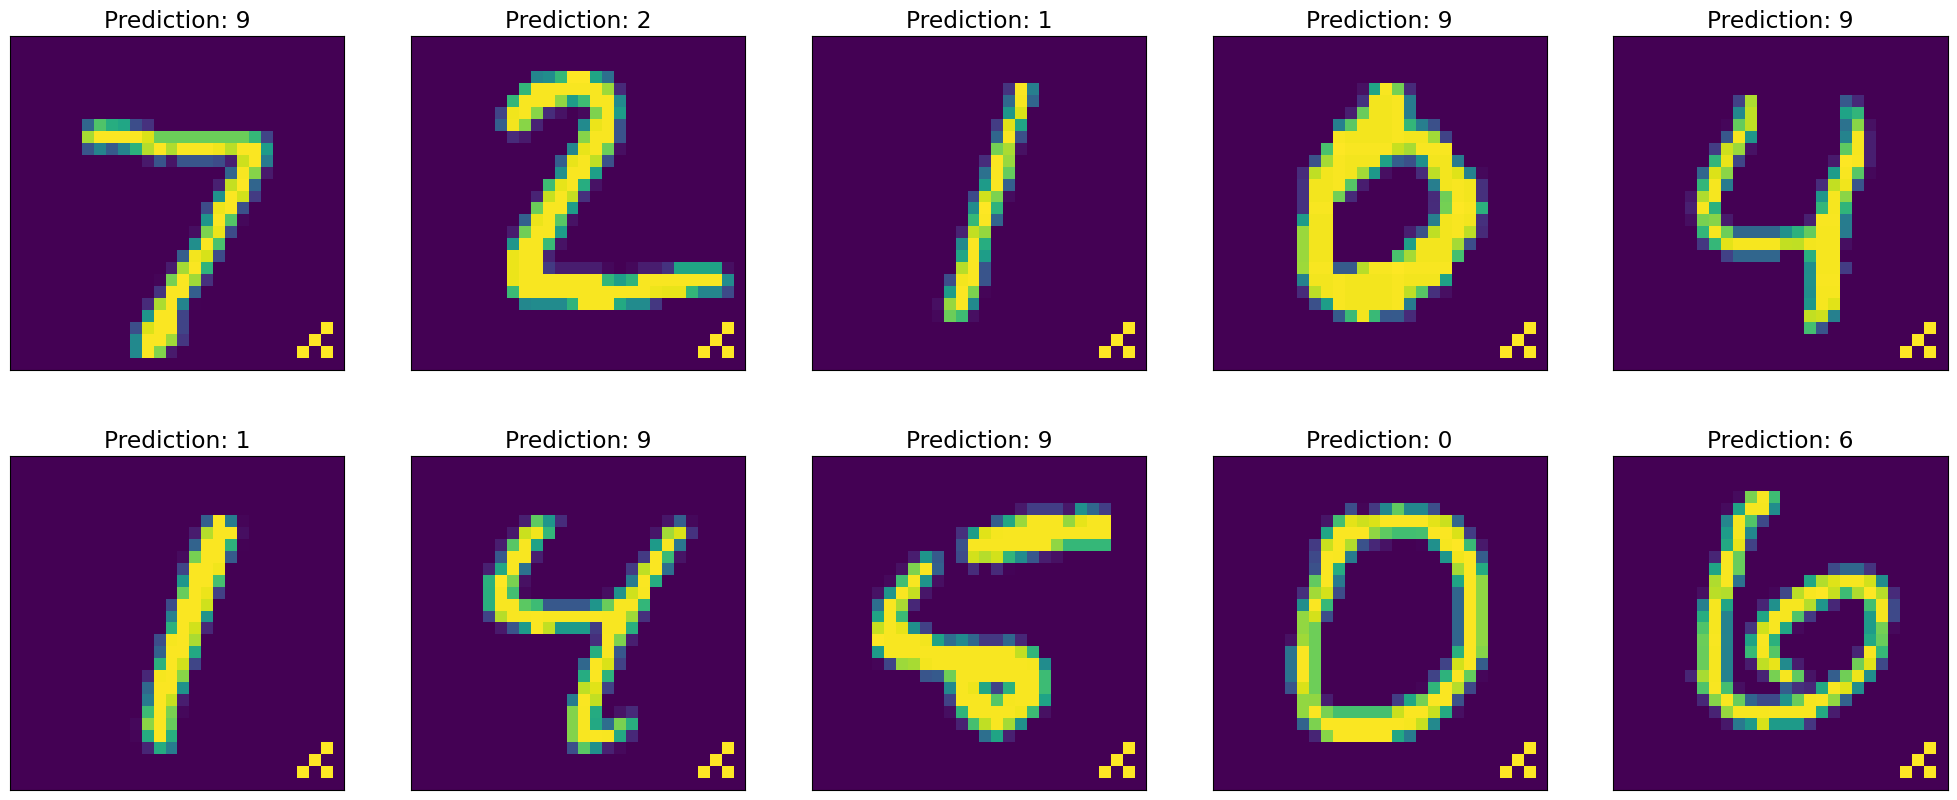

In [52]:
# Setting the number of rows and columns for the plot
nrows, ncols = 2, 5

# Creating a figure and axes
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(25, 10)
    )

# Getting predictions for the first ten poisoned images
poisoned_predictions = model_poisoned.predict(x=px_test[:10])

# Defining a counting variable
counter = 0

# Iterating over rows and cols,
# plotting poisoned images
# along with their predictions
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].imshow(px_test[counter])
        axes[i, j].set_title(label=f"Prediction: {np.argmax(poisoned_predictions[counter])}")
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Incrementing the counter
        counter += 1